In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import trimesh

import postprocess_dataset
from utils import utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1

In [4]:
# displays meshes at the predicted pose
def show_meshes(cfg, device, saved_model_path, gt_shapes_dict, only_show_instances=[], num_novel_view=3, compute_metrics=True, print_info=True):
    input_dir_img = cfg['dataset']['input_dir_img']
    input_dir_mesh = cfg['dataset']['input_dir_mesh']
    output_dir = "{}_{}".format(input_dir_mesh, exp_name)
    
    # combining all cached predicted poses
    cached_pred_poses = {}
    pred_pose_paths = list(Path(output_dir).rglob('pred_poses.p'))
    for pred_pose_path in pred_pose_paths:
        curr_cache = pickle.load(open(pred_pose_path, "rb"))
        cached_pred_poses = {**cached_pred_poses, **curr_cache}
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(saved_model_path).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if len(only_show_instances) == 0 or instance_name in only_show_instances:
            for processed_mesh_path in processed_paths_dict[instance_name]:
            
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                # loading trimesh and pytorch3d meshes for the g.t., originally reconstructed, and refined model
                original_mesh_path = os.path.join(input_dir_mesh, instance_name+".obj")
                with torch.no_grad():
                    mesh_original = utils.load_untextured_mesh(original_mesh_path, device)
                    mesh_processed = utils.load_untextured_mesh(processed_mesh_path, device)
                mesh_original_trimesh = trimesh.load(original_mesh_path)
                mesh_processed_trimesh = trimesh.load(processed_mesh_path)
                
                # rendering gt, original, and processed mesh at predicted pose
                pred_dist = cached_pred_poses[instance_name]['dist']
                pred_elev = cached_pred_poses[instance_name]['elev']
                pred_azim = cached_pred_poses[instance_name]['azim']
                R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim)
                mesh_original_render = utils.render_mesh(mesh_original, R, T, device)
                mesh_processed_render = utils.render_mesh(mesh_processed, R, T, device)
                
                # rendering processed mesh at poses other than the predicted pose
                novel_view_renders = []
                for i in range(num_novel_view):
                    R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim+ ((i+1)*45))
                    novel_view_renders.append(utils.render_mesh(mesh_processed, R, T, device))
                
                # computing performance metrics before refinement
                if compute_metrics:
                    gt_mesh_path = gt_shapes_dict[instance_name]
                    with torch.no_grad():
                        mesh_gt = utils.load_untextured_mesh(gt_mesh_path, device)
                    mesh_gt_trimesh = trimesh.load(gt_mesh_path)
                    mesh_gt_render = utils.render_mesh(mesh_gt, R, T, device)
                    
                    #iou_2d_before = compute_iou_2d(mesh_original, input_image, device)
                    iou_2d_before = compute_iou_2d_given_pose(mesh_original, input_image, device, pred_azim, pred_elev, pred_dist)
                    iou_3d_before = compute_iou_3d(mesh_original_trimesh, mesh_original, mesh_gt_trimesh, mesh_gt)
                    chamfer_before = compute_chamfer_L1(mesh_original_trimesh, mesh_original, mesh_gt_trimesh, mesh_gt)
                    # computing metrics after refinement
                    #iou_2d_after = compute_iou_2d(mesh_processed, input_image, device)
                    # TODO: not sure if using the original pred pose for the processed iou is legitimate
                    iou_2d_after = compute_iou_2d_given_pose(mesh_processed, input_image, device, pred_azim, pred_elev, pred_dist)
                    iou_3d_after = compute_iou_3d(mesh_processed_trimesh, mesh_processed, mesh_gt_trimesh, mesh_gt)
                    chamfer_after = compute_chamfer_L1(mesh_processed_trimesh, mesh_processed, mesh_gt_trimesh, mesh_gt)
                    num_columns = 4+num_novel_view
                else:
                    iou_2d_before = 0
                    iou_3d_before = 0
                    chamfer_before = 0
                    iou_2d_after = 0
                    iou_3d_after = 0
                    chamfer_after = 0
                    num_columns = 3+num_novel_view

                # visualizing
                if print_info:
                    print(processed_mesh_path)
                    print("Metrics before refinement -- 2d IoU: {}, 3d IoU: {}, Chamfer dist: {}".format(iou_2d_before, iou_3d_before, chamfer_before))
                    print("Metrics after refinement -- 2d IoU: {}, 3d IoU: {}, Chamfer dist: {}".format(iou_2d_after, iou_3d_after, chamfer_after))
                
                fig, ax = plt.subplots(nrows=1, ncols=num_columns, squeeze=False, figsize=(15,5))
                col_i = 0
                ax[0][col_i].imshow(input_image)
                ax[0][col_i].xaxis.set_visible(False)
                ax[0][col_i].yaxis.set_visible(False)
                
                if compute_metrics:
                    col_i += 1
                    ax[0][col_i].imshow(mesh_gt_render[0, ..., :3].cpu().numpy())
                    ax[0][col_i].xaxis.set_visible(False)
                    ax[0][col_i].yaxis.set_visible(False)      

                col_i += 1
                ax[0][col_i].imshow(mesh_original_render[0, ..., :3].cpu().numpy())
                ax[0][col_i].xaxis.set_visible(False)
                ax[0][col_i].yaxis.set_visible(False)

                col_i += 1
                ax[0][col_i].imshow(mesh_processed_render[0, ..., :3].cpu().numpy())
                ax[0][col_i].xaxis.set_visible(False)
                ax[0][col_i].yaxis.set_visible(False)
                
                col_i += 1
                for i in range(num_novel_view):
                    ax[0][col_i+i].imshow(novel_view_renders[i][0, ..., :3].cpu().numpy())
                    ax[0][col_i+i].xaxis.set_visible(False)
                    ax[0][col_i+i].yaxis.set_visible(False)
                plt.pause(0.05)

In [5]:
cfg_path = "configs/refine2.yaml"
exp_name = "processed"
gt_shapes_path = "/home/svcl-oowl/brandon/research/sil_consistent_at_inference/data_evaluation/pix3d_chair/pix3d_chair_gt_shapes.lst"


cfg = utils.load_config(cfg_path, "configs/default.yaml")
device = torch.device("cuda:0")
gt_shapes_dict = {}
with open(gt_shapes_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]
processed_model_path = cfg['dataset']['input_dir_mesh']+"_{}".format(exp_name)

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0238.obj
Metrics before refinement -- 2d IoU: 0.4438963298630032, 3d IoU: 0.16138328611850739, Chamfer dist: 0.004474579822272062
Metrics after refinement -- 2d IoU: 0.9320262636216755, 3d IoU: 0.019523421302437782, Chamfer dist: 0.024476276710629463


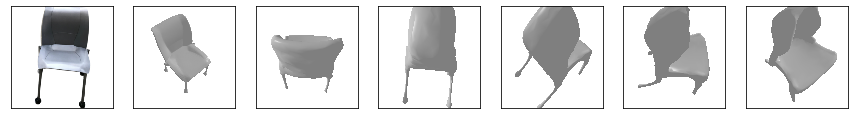

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0102.obj
Metrics before refinement -- 2d IoU: 0.7233490897177891, 3d IoU: 0.24202166497707367, Chamfer dist: 0.00334896775893867
Metrics after refinement -- 2d IoU: 0.9247874303323125, 3d IoU: 0.0047093890607357025, Chamfer dist: 0.013045264407992363


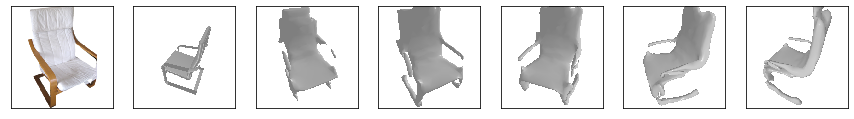

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0052.obj
Metrics before refinement -- 2d IoU: 0.4035415460716729, 3d IoU: 0.18320389091968536, Chamfer dist: 0.00308661675080657
Metrics after refinement -- 2d IoU: 0.701278078411421, 3d IoU: 0.0654364824295044, Chamfer dist: 0.004297996871173382


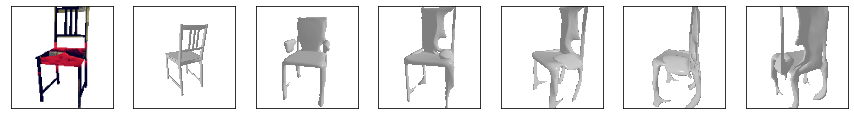

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0151.obj
Metrics before refinement -- 2d IoU: 0.7585379263676542, 3d IoU: 0.33311727643013, Chamfer dist: 0.004045567475259304
Metrics after refinement -- 2d IoU: 0.8979630623378947, 3d IoU: 0.270549476146698, Chamfer dist: 0.006933574564754963


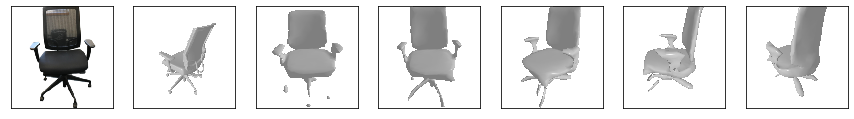

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0476.obj
Metrics before refinement -- 2d IoU: 0.6389109341798725, 3d IoU: 0.400503545999527, Chamfer dist: 0.003935572691261768
Metrics after refinement -- 2d IoU: 0.8835507830973377, 3d IoU: 0.2985239028930664, Chamfer dist: 0.006112614646553993


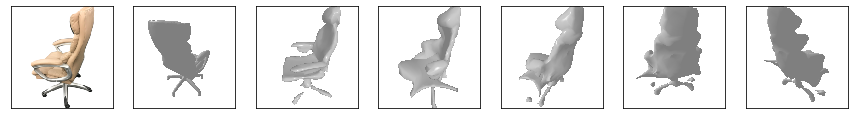

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0042.obj
Metrics before refinement -- 2d IoU: 0.5663162210443085, 3d IoU: 0.2778817117214203, Chamfer dist: 0.006538826506584883
Metrics after refinement -- 2d IoU: 0.9451555110802653, 3d IoU: 0.01757284812629223, Chamfer dist: 0.03448336943984032


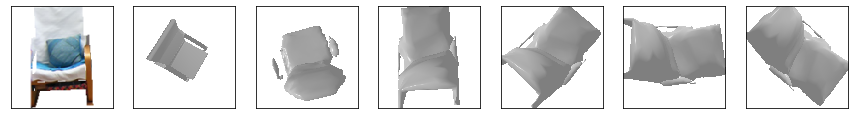

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0370.obj
Metrics before refinement -- 2d IoU: 0.6325328939397611, 3d IoU: 0.21323636174201965, Chamfer dist: 0.013002138584852219
Metrics after refinement -- 2d IoU: 0.8893002521698888, 3d IoU: 0.09931506961584091, Chamfer dist: 0.03984319046139717


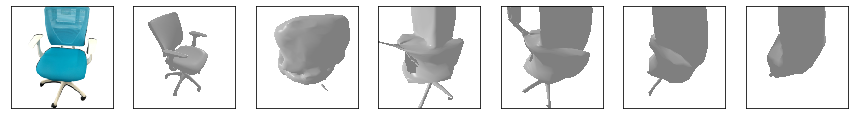

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0675.obj
Metrics before refinement -- 2d IoU: 0.6254361620046754, 3d IoU: 0.30163753032684326, Chamfer dist: 0.002019695471972227
Metrics after refinement -- 2d IoU: 0.8747207192656599, 3d IoU: 0.17741934955120087, Chamfer dist: 0.006471931003034115


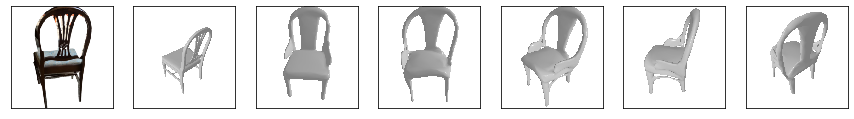

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0627.obj
Metrics before refinement -- 2d IoU: 0.3899932759780004, 3d IoU: 0.0627758726477623, Chamfer dist: 0.021789763122797012
Metrics after refinement -- 2d IoU: 0.7772931076431129, 3d IoU: 0.012171393260359764, Chamfer dist: 0.0628972202539444


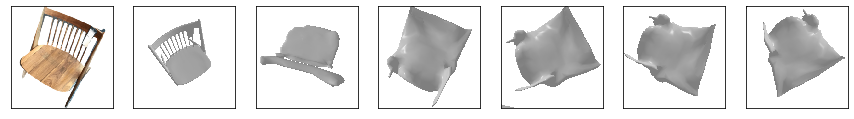

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0030.obj
Metrics before refinement -- 2d IoU: 0.6311411310766798, 3d IoU: 0.24857214093208313, Chamfer dist: 0.01031240914016962
Metrics after refinement -- 2d IoU: 0.9225463105106949, 3d IoU: 0.11167721450328827, Chamfer dist: 0.016740133985877037


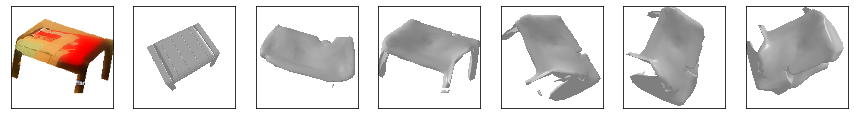

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0409.obj
Metrics before refinement -- 2d IoU: 0.6097190681534026, 3d IoU: 0.5067775845527649, Chamfer dist: 0.0026415488682687283
Metrics after refinement -- 2d IoU: 0.0, 3d IoU: 0.0, Chamfer dist: 20.748737335205078


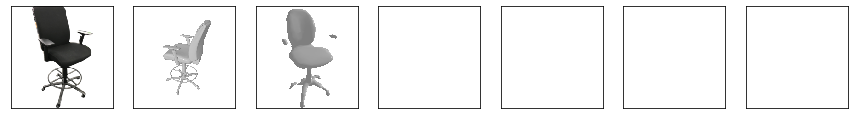

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0496.obj
Metrics before refinement -- 2d IoU: 0.6290185646366312, 3d IoU: 0.3537042438983917, Chamfer dist: 0.004347874782979488
Metrics after refinement -- 2d IoU: 0.9027883937700394, 3d IoU: 0.2769935727119446, Chamfer dist: 0.006540994625538588


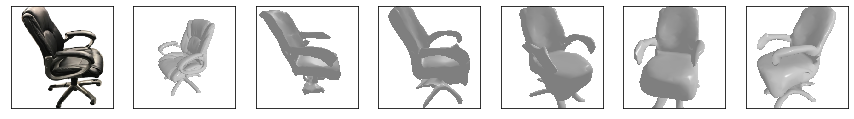

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0274.obj
Metrics before refinement -- 2d IoU: 0.42691210540417013, 3d IoU: 0.07942602783441544, Chamfer dist: 0.003471525851637125
Metrics after refinement -- 2d IoU: 0.7322788287934688, 3d IoU: 0.06909333169460297, Chamfer dist: 0.01133854128420353


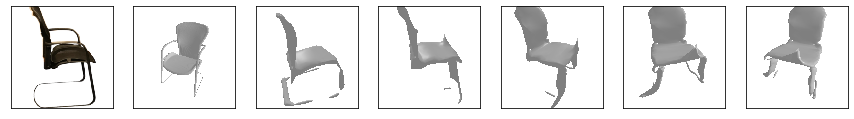

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0644.obj
Metrics before refinement -- 2d IoU: 0.7536228496634256, 3d IoU: 0.175872802734375, Chamfer dist: 0.0016204256098717451
Metrics after refinement -- 2d IoU: 0.9086614559687849, 3d IoU: 0.09857962280511856, Chamfer dist: 0.009335634298622608


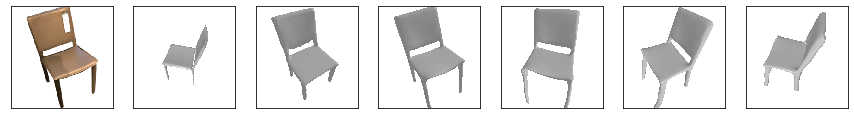

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0036.obj
Metrics before refinement -- 2d IoU: 0.6073724724887516, 3d IoU: 0.22333981096744537, Chamfer dist: 0.003953048028051853
Metrics after refinement -- 2d IoU: 0.8989659303718696, 3d IoU: 0.14305686950683594, Chamfer dist: 0.007726001087576151


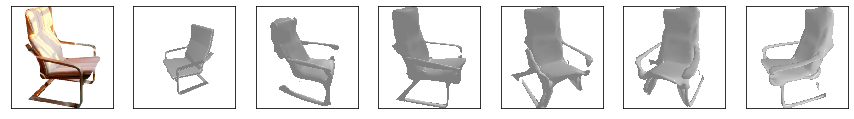

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0578.obj
Metrics before refinement -- 2d IoU: 0.7252993914859938, 3d IoU: 0.31658995151519775, Chamfer dist: 0.00573074072599411
Metrics after refinement -- 2d IoU: 0.8738110247250823, 3d IoU: 0.1171642392873764, Chamfer dist: 0.007610077038407326


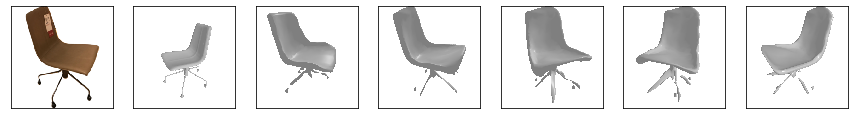

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0260.obj
Metrics before refinement -- 2d IoU: 0.6462906198562967, 3d IoU: 0.5044247508049011, Chamfer dist: 0.002380010671913624
Metrics after refinement -- 2d IoU: 0.8921034086272764, 3d IoU: 0.3391134738922119, Chamfer dist: 0.0052842749282717705


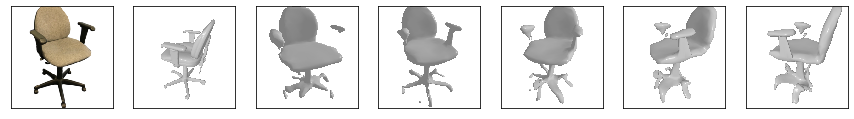

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0215.obj
Metrics before refinement -- 2d IoU: 0.6348556151404763, 3d IoU: 0.1897285431623459, Chamfer dist: 0.0023193347733467817
Metrics after refinement -- 2d IoU: 0.8165448481407891, 3d IoU: 0.08773679286241531, Chamfer dist: 0.006667446345090866


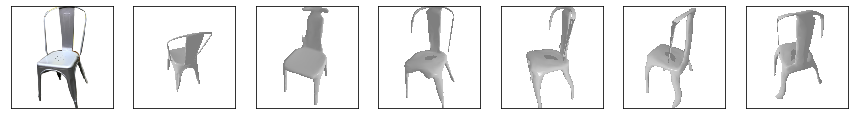

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0243.obj
Metrics before refinement -- 2d IoU: 0.6083580823080187, 3d IoU: 0.33368954062461853, Chamfer dist: 0.0007950501749292016
Metrics after refinement -- 2d IoU: 0.7873840100382631, 3d IoU: 0.12456140667200089, Chamfer dist: 0.004698542412370443


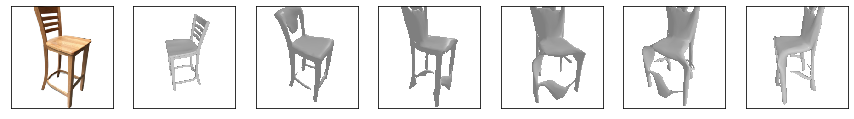

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0539.obj
Metrics before refinement -- 2d IoU: 0.7100047242741797, 3d IoU: 0.4412066340446472, Chamfer dist: 0.003176532220095396
Metrics after refinement -- 2d IoU: 0.9188467758013424, 3d IoU: 0.1843751221895218, Chamfer dist: 0.011365114711225033


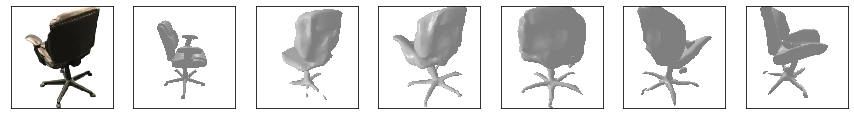

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0321.obj
Metrics before refinement -- 2d IoU: 0.5555157593123209, 3d IoU: 0.07004011422395706, Chamfer dist: 0.003017377108335495
Metrics after refinement -- 2d IoU: 0.8952075212107314, 3d IoU: 0.00011906179133802652, Chamfer dist: 0.012244169600307941


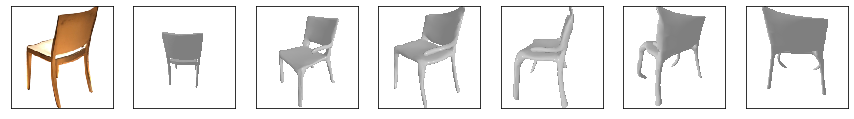

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0523.obj
Metrics before refinement -- 2d IoU: 0.617009639001837, 3d IoU: 0.267809122800827, Chamfer dist: 0.0039463588036596775
Metrics after refinement -- 2d IoU: 0.9141636933722564, 3d IoU: 0.1764409840106964, Chamfer dist: 0.01019985880702734


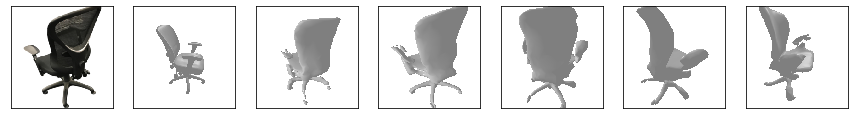

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0655.obj
Metrics before refinement -- 2d IoU: 0.5744248480554831, 3d IoU: 0.16860167682170868, Chamfer dist: 0.004809168633073568
Metrics after refinement -- 2d IoU: 0.8627034042128382, 3d IoU: 0.04569606855511665, Chamfer dist: 0.020128581672906876


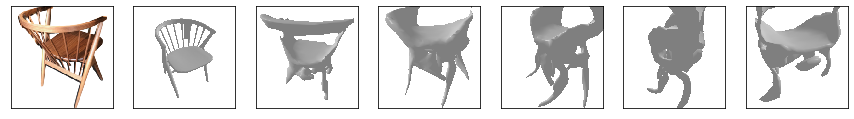

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0475.obj
Metrics before refinement -- 2d IoU: 0.7162229315188929, 3d IoU: 0.5695065259933472, Chamfer dist: 0.0017420346848666668
Metrics after refinement -- 2d IoU: 0.9291431088919891, 3d IoU: 0.181609645485878, Chamfer dist: 0.008332615718245506


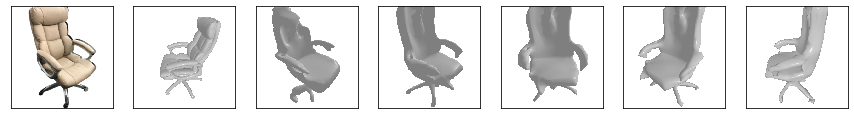

data/onet_chair_pix3d_no_DA_simplified_processed/batch_1_of_5/0566.obj
Metrics before refinement -- 2d IoU: 0.6123211492788044, 3d IoU: 0.06994443386793137, Chamfer dist: 0.02477980963885784
Metrics after refinement -- 2d IoU: 0.9393034744487339, 3d IoU: 0.030027596279978752, Chamfer dist: 0.051513880491256714


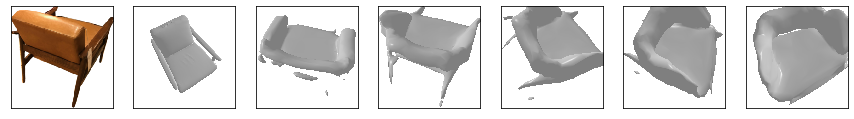

In [9]:
# show postprocessed meshes at predicted angle
instances = random.sample([str(path).split('/')[-1].replace('.obj',"") for path in list(Path(processed_model_path).rglob('*.obj'))], 10)
instances = [ '0238', '0102', '0052', '0151', '0476', '0042', '0370', '0675', '0627', '0030', '0409', '0496', '0274', '0644', '0036', '0578', '0260', '0215', '0243', '0539', '0321', '0523', '0655', '0475', '0566']

show_meshes(cfg, device, processed_model_path, gt_shapes_dict, only_show_instances=instances, compute_metrics=True, print_info=True)
#show_meshes(cfg, device, processed_model_path, gt_shapes_dict, only_show_instances=instances, compute_metrics=False, print_info=False)

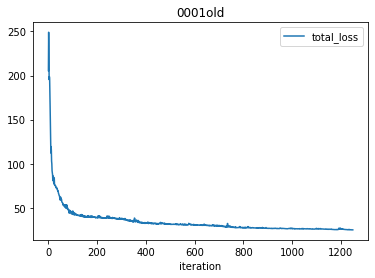

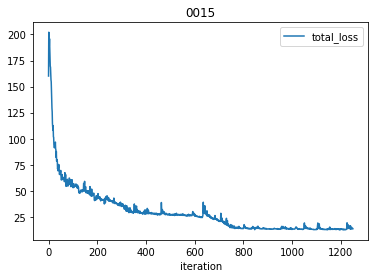

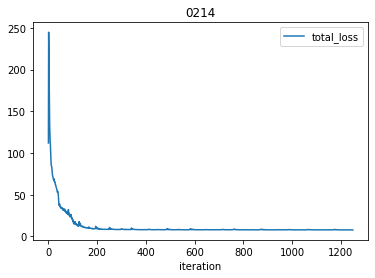

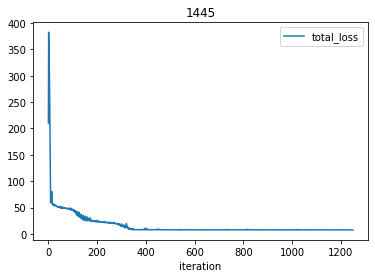

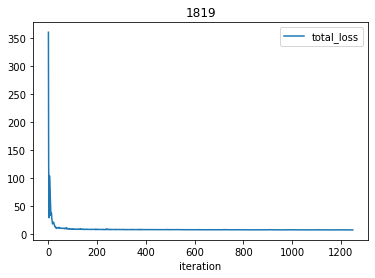

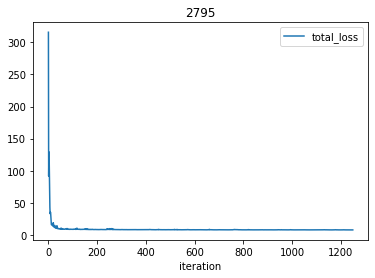

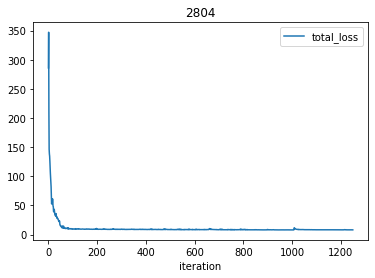

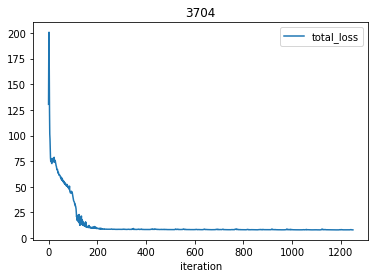

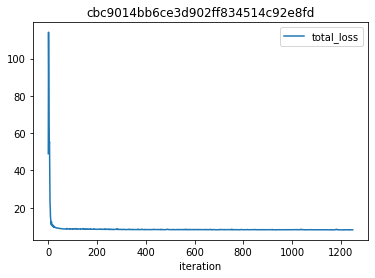

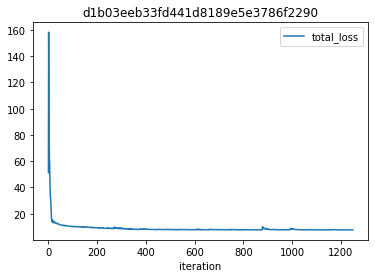

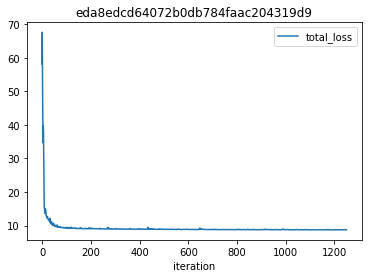

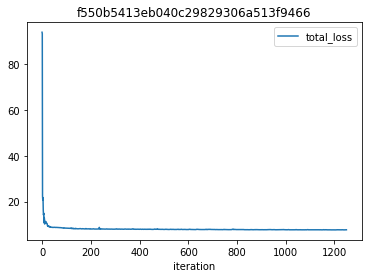

In [28]:
# show training loss info
# getting paths of all loss info pickled files
input_dir_mesh = cfg['dataset']['input_dir_mesh']
output_dir = "{}_{}".format(input_dir_mesh, exp_name)
cached_loss_info_paths = list(Path(output_dir).rglob('loss_info.p'))

for path in cached_loss_info_paths:
    dataset_loss_info = pickle.load(open(path, "rb"))
    for instance_name in dataset_loss_info:
        loss_info = dataset_loss_info[instance_name]
        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance_name))
        #loss_info.plot.line(x='iteration', y='sil_loss')
        #loss_info.plot.line(x='iteration', y='img_sym_loss')
        #loss_info.plot.line(x='iteration', y='vertex_sym_loss')
        #loss_info.plot.line(x='iteration', y='l2_loss')
        #loss_info.plot.line(x='iteration', y='lap_smoothness_loss')
        #loss_info.plot.line(x='iteration', y='normal_consistency_loss')
        #loss_info.plot.line(x='iteration', y='semantic_dis_loss')